# --------ResNet50--------

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input

import os
import cv2
from os import walk
import glob as gb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SEED = 1000
IMG_SIZE = 100
BATCH_SIZE = 24

TRAIN_DIR = 'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/train'
VALID_DIR = 'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/valid'
TEST_DIR = 'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/test'

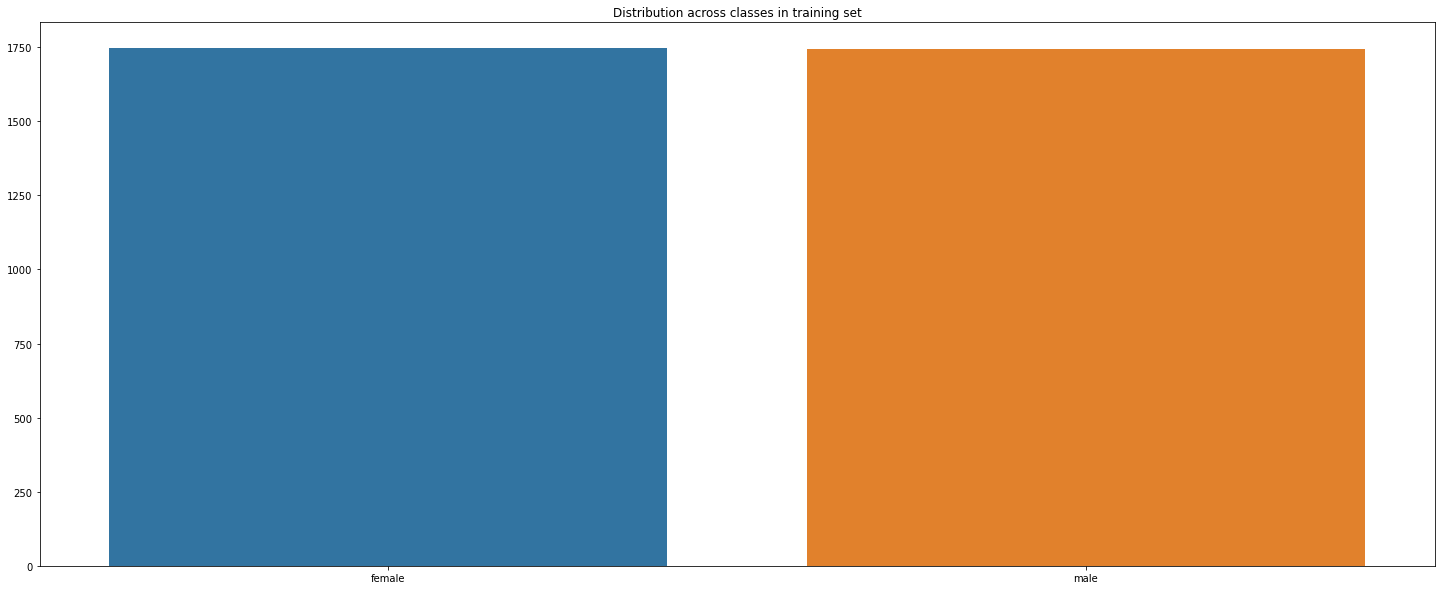

Total Train Examples = 3491


In [3]:
class_names = []
class_count = []
TRAIN_EXAMPLES = 0
for folder in  os.listdir(TRAIN_DIR) : 
    files = gb.glob(pathname= str( TRAIN_DIR + '//' + folder + '/*'))
    class_names.append(folder)
    class_count.append(len(files))
    TRAIN_EXAMPLES += len(files)

plt.figure(figsize=(25,10))    
sns.barplot(x = class_names, y=class_count).set_title("Distribution across classes in training set")
plt.show()

print(f'Total Train Examples = {TRAIN_EXAMPLES}')

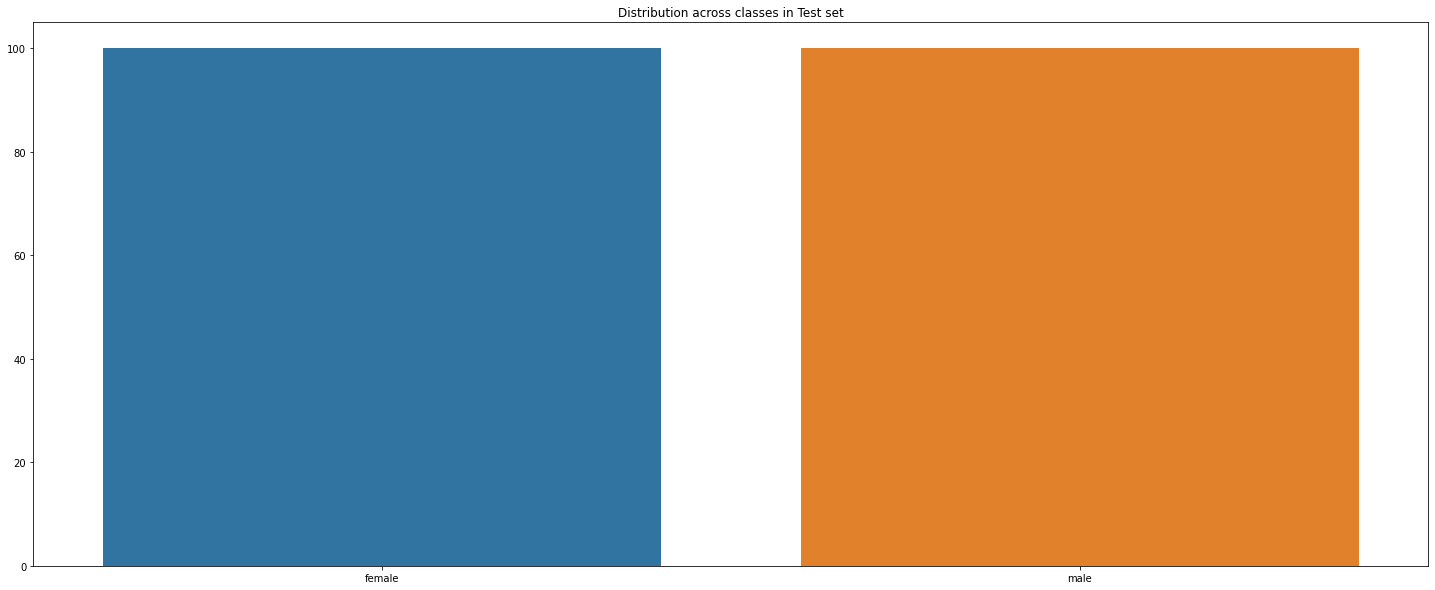

Total Test Examples = 200


In [4]:
class_names = []
class_count = []
Test_EXAMPLES = 0
for folder in  os.listdir(TEST_DIR) : 
    files = gb.glob(pathname= str( TEST_DIR + '//' + folder + '/*'))
    class_names.append(folder)
    class_count.append(len(files))
    Test_EXAMPLES += len(files)

plt.figure(figsize=(25,10))     
sns.barplot(x = class_names, y=class_count).set_title("Distribution across classes in Test set")
plt.show()

print(f'Total Test Examples = {Test_EXAMPLES}')

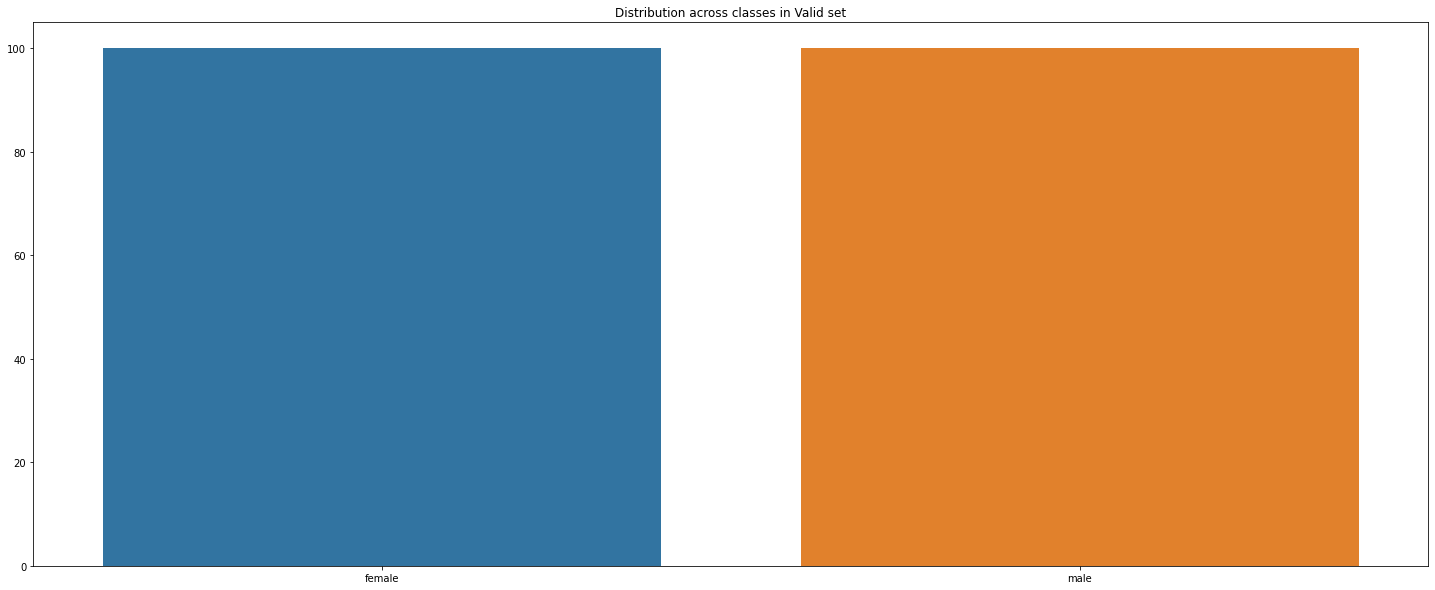

Total Validation Examples = 200


In [5]:
class_names = []
class_count = []
VALIDATION_EXAMPLES = 0
for folder in  os.listdir(VALID_DIR) : 
    files = gb.glob(pathname= str( VALID_DIR + '//' + folder + '/*'))
    class_names.append(folder)
    class_count.append(len(files))
    VALIDATION_EXAMPLES += len(files)

plt.figure(figsize=(25,10))     
sns.barplot(x = class_names, y=class_count).set_title("Distribution across classes in Valid set")
plt.show()

print(f'Total Validation Examples = {VALIDATION_EXAMPLES}')

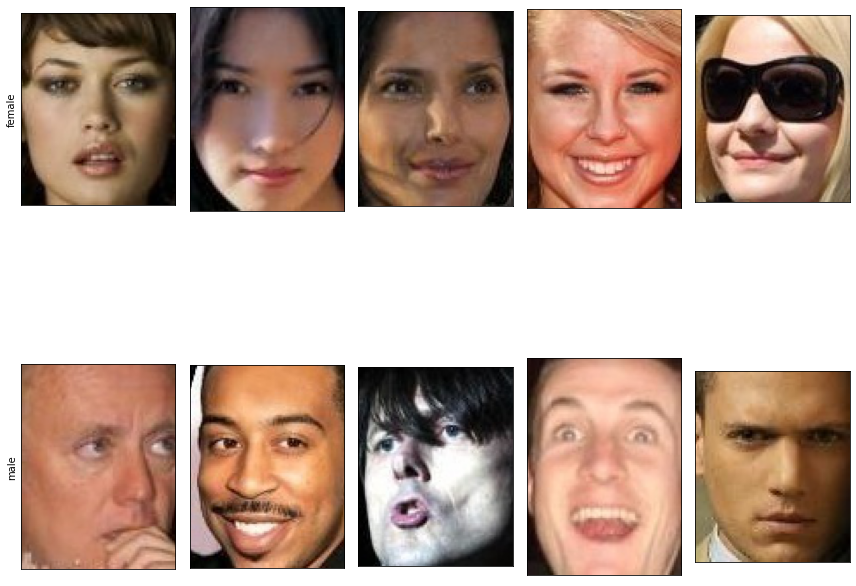

In [6]:
# diaplay 5 images from each class
plt.figure(figsize=(12,12))
i=0
for c in os.listdir(TRAIN_DIR):  
    path = os.path.join(TRAIN_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.cvtColor(cv2.imread(os.path.join(path,img)), cv2.COLOR_BGR2RGB) 
        plt.subplot(2,5,i+1)
        plt.imshow(img_array)
        if i%5 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%5 == 0:
            break

plt.tight_layout()        
plt.show() 

In [7]:
train_gen = ImageDataGenerator(
    
    featurewise_center=False,
    
    samplewise_center=False,
    
    featurewise_std_normalization=False,
    
    samplewise_std_normalization=False,
    
    zca_whitening=False,
    
    zca_epsilon=1e-06,
    
    rotation_range=0.0,
    
    width_shift_range=0.2,
    
    height_shift_range=0.2,
    
    shear_range=0.2,
    
    zoom_range=0.3,
    
    channel_shift_range=0.,
    
    fill_mode='nearest',
    
    cval=0.,
    
    horizontal_flip=False,
    
    vertical_flip=False,
    
    rescale=None,
    
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    
    data_format=None,
    
    
    validation_split=0.0,
    
    dtype=tf.float32,
)

test_gen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet50.preprocess_input, 
    dtype=tf.float32
)

In [8]:
train_batch = train_gen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 3491 images belonging to 2 classes.


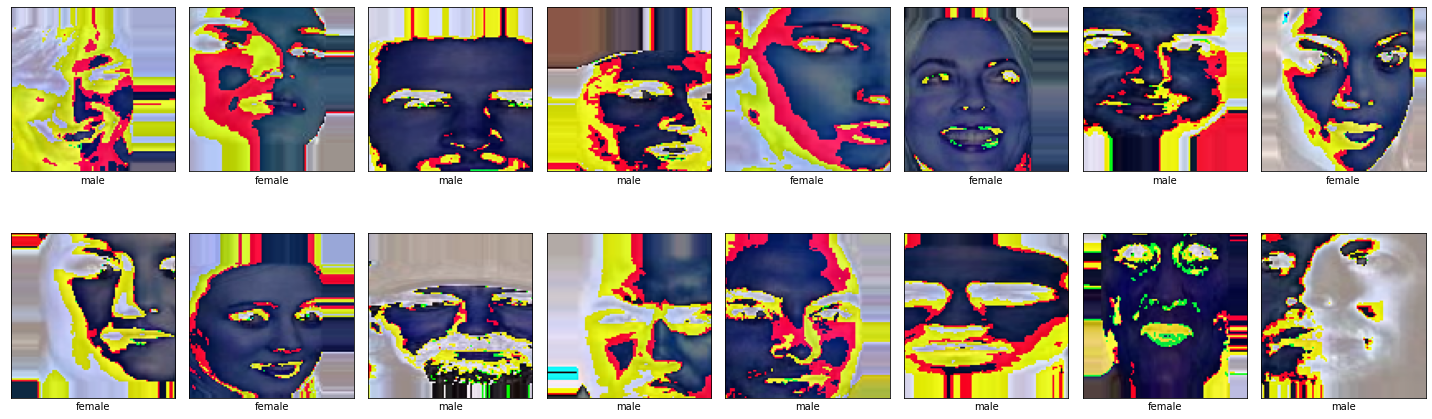

In [9]:

imgs, labels = next(train_batch)
i = 0
plt.figure(figsize=(20,7))
for img, label in zip(imgs, labels):
    plt.subplot(2,8,i+1)
    plt.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[label.astype('int32')])
    i+=1
    if i == 16:
        break
        
plt.tight_layout()
plt.show()

In [10]:
valid_batch = train_gen.flow_from_directory(
    directory = VALID_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 200 images belonging to 2 classes.


In [11]:
test_batch = test_gen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 200 images belonging to 2 classes.


In [12]:
def identity_block(X, filters):
    f1, f2, f3 = filters
    X_copy = X
    
    
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
   
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
   
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [13]:
def conv_blocks(X, filters, s=2):
    f1, f2, f3 = filters
    X_copy = X
    
    
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(s,s), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
    
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
    
    X_copy = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(s,s), padding='valid')(X_copy)
    X_copy = layers.BatchNormalization(axis=3)(X_copy)
    
    
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [14]:
def ResNet50():
    X_input = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    X = layers.ZeroPadding2D((3,3))(X_input)
    
   
    X = layers.Conv2D(64, (7,7), strides=(2,2))(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    X = layers.MaxPooling2D((3,3), strides=(2,2))(X)
    
   
    X = conv_blocks(X, filters=[64,64,256], s=1)
    X = identity_block(X, filters=[64,64,256])
    X = identity_block(X, filters=[64,64,256])
    
   
    X = conv_blocks(X, filters=[128,128,512], s=2)
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    
    
    X = conv_blocks(X, filters=[256,256,1024], s=2)
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    
    
    X = conv_blocks(X, filters=[512,512,2048], s=2)
    X = identity_block(X, filters=[512,512,2048])
    X = identity_block(X, filters=[512,512,2048])
    
    
    X = layers.AveragePooling2D((2,2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(2, activation='softmax', kernel_initializer='he_normal')(X)
    
    model = keras.Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [15]:
model = ResNet50()
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 64)  256         ['conv2d[0][0]']          

In [16]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=lr_schedule(0)), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

Learning rate:  0.001


D:\ML\envs\gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
h = model.fit(train_batch, 
              epochs=50,
              steps_per_epoch = TRAIN_EXAMPLES // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = VALIDATION_EXAMPLES // BATCH_SIZE,
              callbacks=lr_scheduler,
              verbose=2
             )

Learning rate:  0.001
Epoch 1/50
145/145 - 33s - loss: 1.0323 - accuracy: 0.5552 - val_loss: 0.7829 - val_accuracy: 0.5052 - lr: 0.0010 - 33s/epoch - 229ms/step
Learning rate:  0.001
Epoch 2/50
145/145 - 19s - loss: 0.5750 - accuracy: 0.7110 - val_loss: 0.6394 - val_accuracy: 0.6719 - lr: 0.0010 - 19s/epoch - 129ms/step
Learning rate:  0.001
Epoch 3/50
145/145 - 19s - loss: 0.4412 - accuracy: 0.7975 - val_loss: 0.3857 - val_accuracy: 0.8281 - lr: 0.0010 - 19s/epoch - 129ms/step
Learning rate:  0.001
Epoch 4/50
145/145 - 19s - loss: 0.3620 - accuracy: 0.8428 - val_loss: 0.5123 - val_accuracy: 0.7917 - lr: 0.0010 - 19s/epoch - 129ms/step
Learning rate:  0.001
Epoch 5/50
145/145 - 19s - loss: 0.3141 - accuracy: 0.8670 - val_loss: 0.3279 - val_accuracy: 0.8698 - lr: 0.0010 - 19s/epoch - 129ms/step
Learning rate:  0.001
Epoch 6/50
145/145 - 19s - loss: 0.2721 - accuracy: 0.8930 - val_loss: 0.5207 - val_accuracy: 0.8073 - lr: 0.0010 - 19s/epoch - 130ms/step
Learning rate:  0.001
Epoch 7/50
1

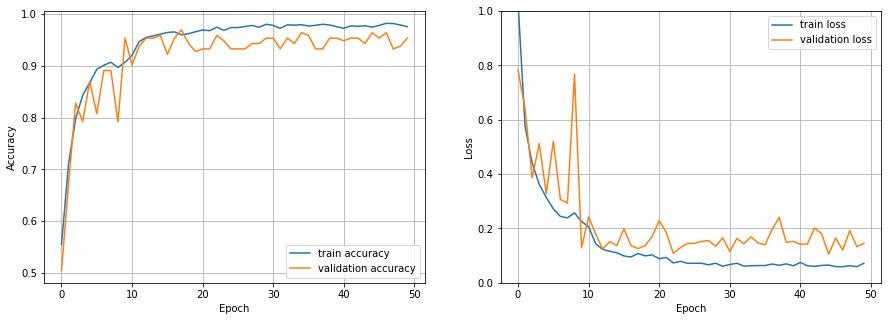

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],  label='train accuracy')
plt.plot(h.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'],  label='train loss')
plt.plot(h.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,1])
plt.legend(loc='upper right')

plt.show()

# --------CNN Architecture-------

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
train_male_dir = os.path.join('D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/train/male/')


train_female_dir = os.path.join('D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/train/female/')


validation_male_dir = os.path.join('D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/valid/male/')


validation_female_dir = os.path.join('D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/valid/female/')

In [22]:
model_cnn = tf.keras.models.Sequential([
   
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dropout(0.3), 
    
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dropout(0.3), 
    
    tf.keras.layers.Dense(2, activation='softmax')
])

In [23]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_54 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_55 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0

In [24]:
model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=lr_schedule(0)),
    metrics=['accuracy'])

Learning rate:  0.001


In [25]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_directory(
        'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/train/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True)


validation_generator = validation_datagen.flow_from_directory(
        'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/valid/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse')


Found 3491 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [26]:
history_cnn = model_cnn.fit(
      train_generator,
      steps_per_epoch=32,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator
      )

Epoch 1/50
32/32 [==============================] - 2s 32ms/step - loss: 0.6952 - accuracy: 0.5086 - val_loss: 0.6982 - val_accuracy: 0.5000
Epoch 2/50
32/32 [==============================] - 1s 16ms/step - loss: 0.6910 - accuracy: 0.5091 - val_loss: 0.6612 - val_accuracy: 0.6300
Epoch 3/50
32/32 [==============================] - 1s 15ms/step - loss: 0.6346 - accuracy: 0.6419 - val_loss: 0.6852 - val_accuracy: 0.5900
Epoch 4/50
32/32 [==============================] - 1s 16ms/step - loss: 0.5469 - accuracy: 0.7370 - val_loss: 0.5253 - val_accuracy: 0.7500
Epoch 5/50
32/32 [==============================] - 1s 16ms/step - loss: 0.4983 - accuracy: 0.7708 - val_loss: 0.3683 - val_accuracy: 0.8400
Epoch 6/50
32/32 [==============================] - 1s 15ms/step - loss: 0.4286 - accuracy: 0.8216 - val_loss: 0.2859 - val_accuracy: 0.8650
Epoch 7/50
32/32 [==============================] - 1s 16ms/step - loss: 0.3782 - accuracy: 0.8568 - val_loss: 0.3025 - val_accuracy: 0.8800
Epoch 8/50
32

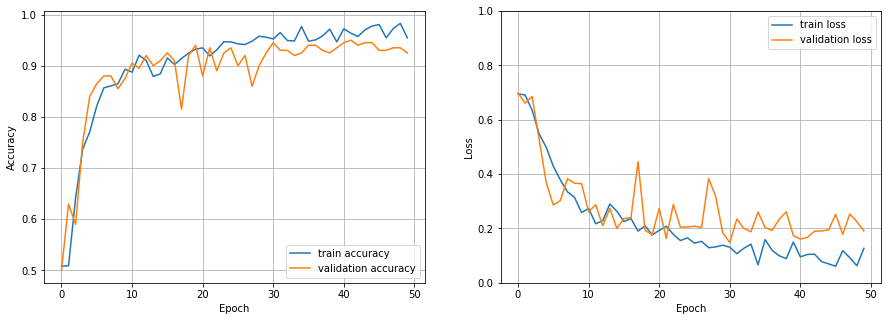

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'],  label='train accuracy')
plt.plot(history_cnn.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'],  label='train loss')
plt.plot(history_cnn.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,1])
plt.legend(loc='upper right')

plt.show()

# -------VGG16----------

In [3]:
from glob import glob
training_dir=TRAIN_DIR
validation_dir=VALID_DIR
image_files = glob(training_dir + '/*/*')
valid_image_files = glob(validation_dir + '/*/*')

In [4]:
folders = glob(training_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 2


In [5]:
from keras.models import Model
from keras.layers import Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16

IMG_SIZE=80

IMAGE_SIZE = [IMG_SIZE, IMG_SIZE] 


vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False) 


for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)

x = Dense(num_classes, activation = 'softmax')(x)  

model = Model(inputs = vgg.input, outputs = x)

model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='Adam', 
    metrics=['accuracy']
)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 20, 128)       0     

In [6]:
training_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    shear_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=False,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(
    training_dir, 
    target_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE, 
    class_mode = 'sparse')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    target_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE, 
    class_mode = 'sparse')

Found 3491 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [33]:
training_images = 3491
validation_images = 200

history = model.fit(training_generator,
                   steps_per_epoch = 20,
                   epochs = 50,
                   validation_data = validation_generator,
                   )
                   
                             

Epoch 1/50
20/20 [==============================] - 4s 103ms/step - loss: 0.6806 - accuracy: 0.5729 - val_loss: 0.5585 - val_accuracy: 0.7550
Epoch 2/50
20/20 [==============================] - 1s 56ms/step - loss: 0.5569 - accuracy: 0.7396 - val_loss: 0.5511 - val_accuracy: 0.6900
Epoch 3/50
20/20 [==============================] - 1s 56ms/step - loss: 0.4777 - accuracy: 0.7937 - val_loss: 0.4476 - val_accuracy: 0.8100
Epoch 4/50
20/20 [==============================] - 1s 56ms/step - loss: 0.4583 - accuracy: 0.8083 - val_loss: 0.4546 - val_accuracy: 0.7700
Epoch 5/50
20/20 [==============================] - 1s 56ms/step - loss: 0.4347 - accuracy: 0.8146 - val_loss: 0.4194 - val_accuracy: 0.8200
Epoch 6/50
20/20 [==============================] - 1s 56ms/step - loss: 0.3947 - accuracy: 0.8354 - val_loss: 0.4071 - val_accuracy: 0.8200
Epoch 7/50
20/20 [==============================] - 1s 57ms/step - loss: 0.4015 - accuracy: 0.8375 - val_loss: 0.3868 - val_accuracy: 0.8050
Epoch 8/50
2

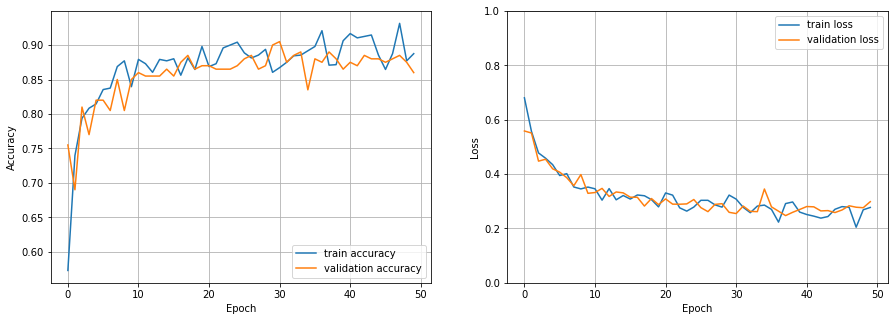

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],  label='train accuracy')
plt.plot(history.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],  label='train loss')
plt.plot(history.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,1])
plt.legend(loc='upper right')

plt.show()

# -------Filter Visualization (VGG16)-------

In [7]:
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib as mpl

In [8]:
model = vgg
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 80, 80, 64)
2 block1_conv2 (None, 80, 80, 64)
4 block2_conv1 (None, 40, 40, 128)
5 block2_conv2 (None, 40, 40, 128)
7 block3_conv1 (None, 20, 20, 256)
8 block3_conv2 (None, 20, 20, 256)
9 block3_conv3 (None, 20, 20, 256)
11 block4_conv1 (None, 10, 10, 512)
12 block4_conv2 (None, 10, 10, 512)
13 block4_conv3 (None, 10, 10, 512)
15 block5_conv1 (None, 5, 5, 512)
16 block5_conv2 (None, 5, 5, 512)
17 block5_conv3 (None, 5, 5, 512)


In [9]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    
    return img

In [10]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

Image shape: (1, 512, 394, 3)


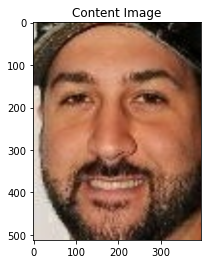

In [11]:
content_path = 'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/train/male/0018.jpg'
content_image = load_img(content_path)
print('Image shape:', content_image.shape)
imshow(content_image, 'Content Image')

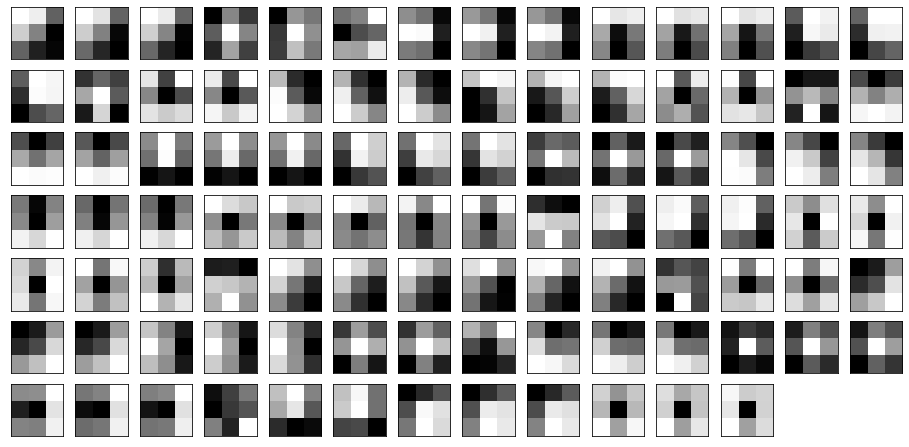

In [12]:
plt.figure(figsize=(16,16))

filters, biases = model.layers[1].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 32, 1

for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = pyplot.subplot(14, 14, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
pyplot.show()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 80, 64)        1792      
                                                                 
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


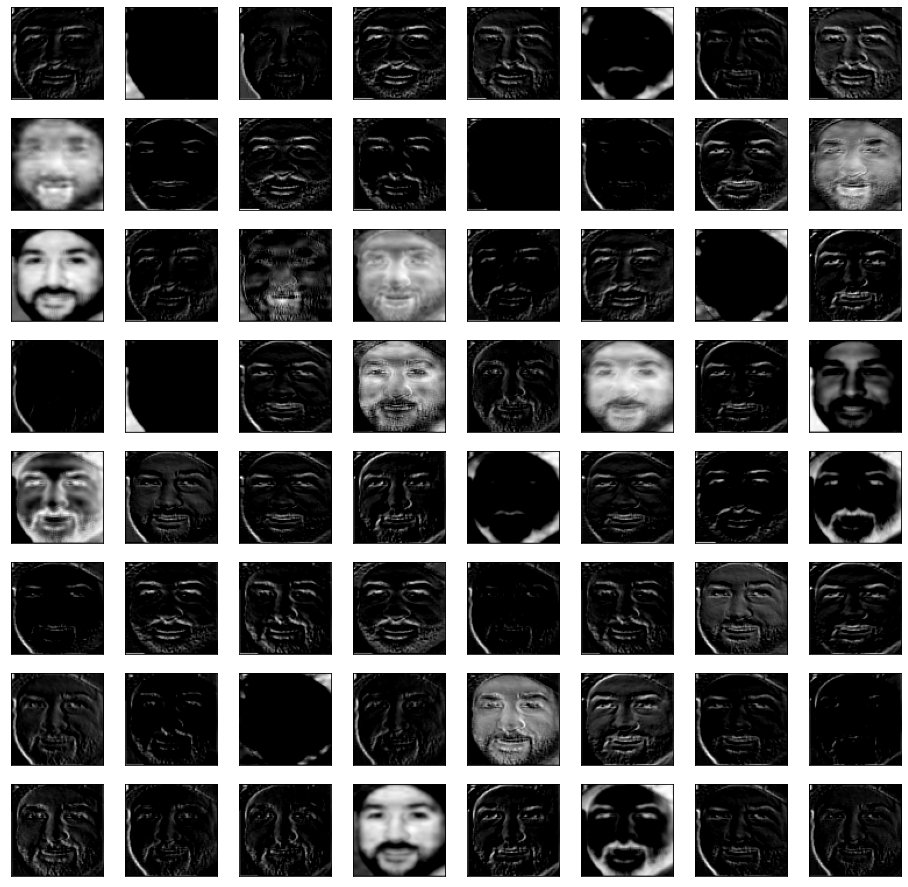

In [13]:
plt.figure(figsize=(16,16))

model = tf.keras.Model(inputs=[vgg.input], outputs=vgg.layers[1].output)
model.summary()

content_image = tf.keras.applications.vgg16.preprocess_input(content_image*255)
content_image = tf.image.resize(content_image, (80, 80))

feature_maps = model.predict(content_image)
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
        
pyplot.show()

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 80, 64), dtype=tf.float32, name=None), name='block1_conv2/Relu:0', description="created by layer 'block1_conv2'")


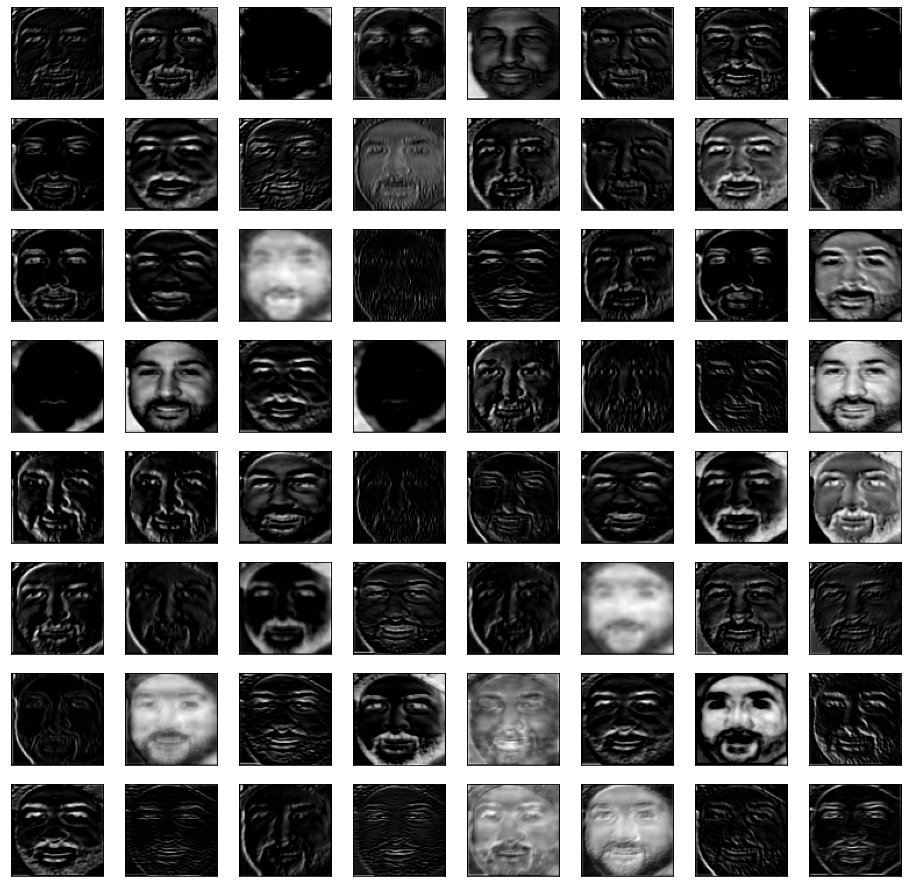

KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 128), dtype=tf.float32, name=None), name='block2_conv2/Relu:0', description="created by layer 'block2_conv2'")


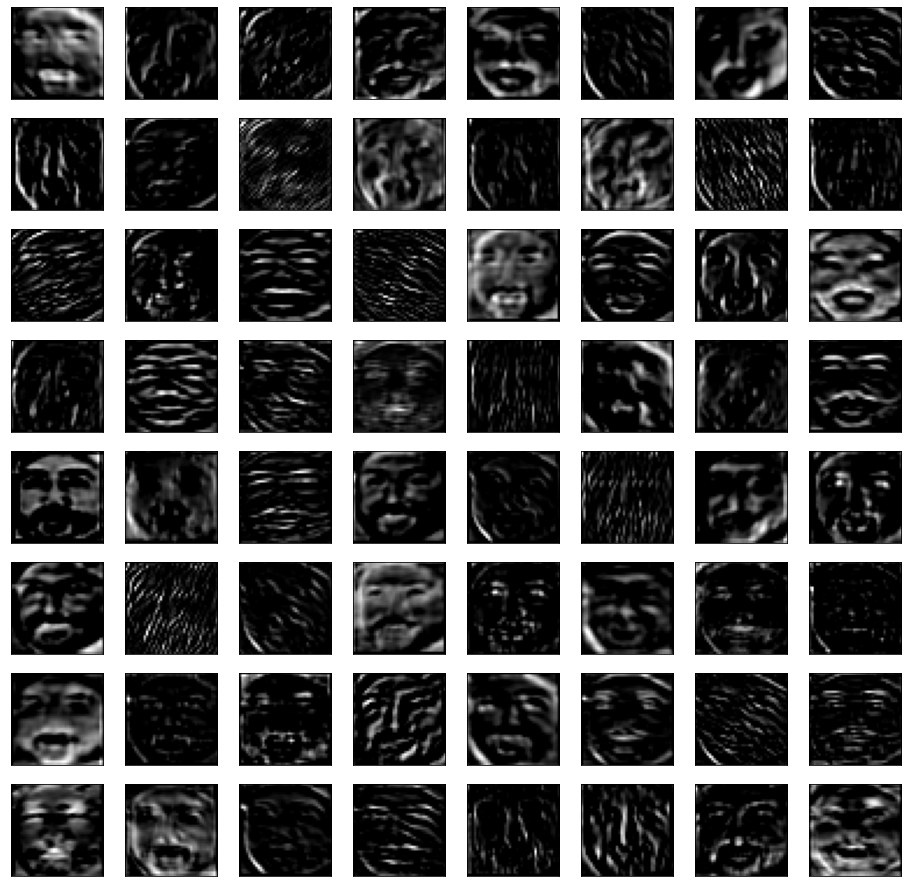

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 10, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")


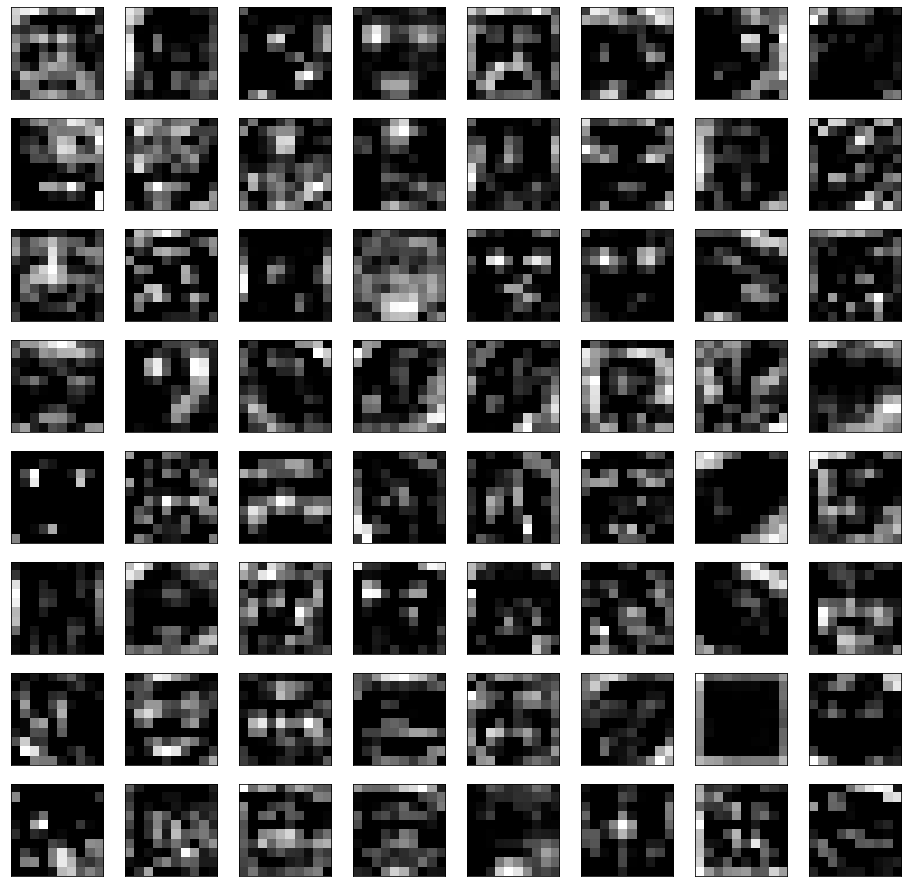

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")


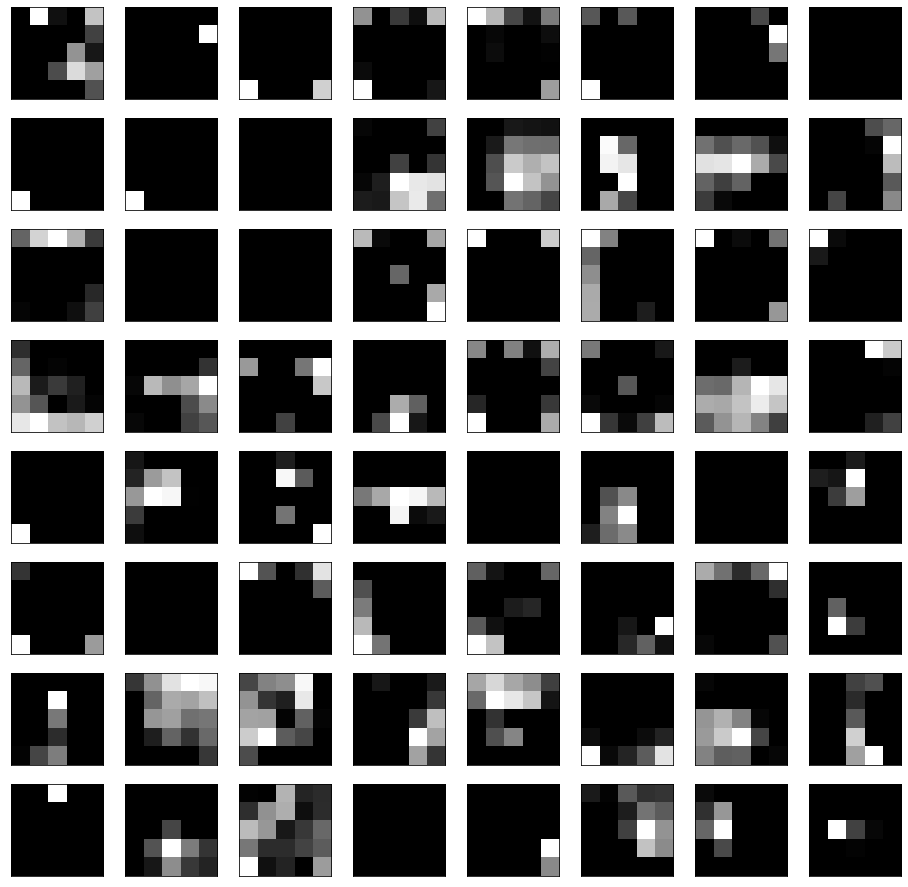

In [14]:
ixs = [2, 5, 10, 15]
outputs = [vgg.layers[i].output for i in ixs]
model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)
feature_maps = model.predict(content_image)

square = 8
for i, fmap in enumerate(feature_maps):
    ix = 1
    print(outputs[i])
    plt.figure(figsize=(16,16))
    for _ in range(square):
        for _ in range(square):
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    pyplot.show()